# OVERVIEW:

This file, TIPP_DLF_Q2.ipynb, is the main file to run for Q2. The Supporting files used for Q2 are
1. CNNModel.py
2. Image.py
3. ImgManager.py
4. Analyser.py

The output for Q2 is at folder /output_Q2 \
The data input for Q2 is at folder /pokemon. \
Additional validation images are added into the subfolders of pokemon. These images starts with val_imagesXX.png

In [1]:
from ImgManager import ImgManager
from CNNModel import CNNModel
from Analyser import Analyser
import warnings
import pandas as pd
import time
import numpy as np
output2='output_Q2/'
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Reading the images and creating class labels
imgMan=ImgManager(testSize=0.2)
imgMan.readImages()


Mapping string lable to int label images...
balbasaur :0
charmander :1
mewtwo :2
pikachu :3
squirtle :4


Reading images from folder balbasaur ...
Reading images from folder charmander ...
Reading images from folder mewtwo ...
Reading images from folder pikachu ...
Reading images from folder squirtle ...
Reading images from folder DONE 



In [3]:
# processing all image objects. Each image object 
# will return a resize image and a denoise image. 
# ImageManager will add and filter this images into a list of train, test and validation
imgMan.procesImages()


Processing all images... 
Test Images100
Train Images 400
Validation Images 100
Processing all images DONE 


In [4]:
#Return train, test and validation data.
X_Train,y_train,X_Test,y_test,X_Val,y_Val=imgMan.get_Train_Test_Val_Data()
print('X_train shape: '+str(X_Train.shape))
print('y_train shape: '+str(y_train.shape))
print('X_test shape: '+str(X_Test.shape))
print('y_test shape: '+str(y_test.shape))
print('X_Val shape: '+str(X_Val.shape))
print('y_Val shape: '+str(y_Val.shape))


X_train shape: (400, 141, 141, 3)
y_train shape: (400, 5)
X_test shape: (100, 141, 141, 3)
y_test shape: (100, 5)
X_Val shape: (100, 141, 141, 3)
y_Val shape: (100, 5)


In [5]:
# create the model
cnnMod=CNNModel(imgMan.getSideDimension(),X_Train,y_train,X_Test,y_test)

In [6]:
#Find the best hyper paramters to get best results
epoch=[5,10]
batSize=[25,20] 
optimizers=['rmsprop','adam']
outAct=['softmax','sigmoid']
hiddenUnit=[256,128]

dictParam={'epochs':epoch,'batch_size':batSize,'anOptimizer':optimizers,'outActivation':outAct,'hidUnit':hiddenUnit}
start=time.time()
df_full,df_result,bestParam,bestScore,model=cnnMod.findOptimizeParamCV(dictParam,fold=2)
end=time.time()

In [7]:
print('Time taken for grid search is '+str(end-start)+" seconds") # Time taken is approx 2. hrs to find optimize params

Time taken for grid search is 7292.924102067947 seconds


In [8]:
#Print full results of searching for optimize param to output_Q2/DF_Full_Result.xlsx
df_full.to_excel(output2+"DF_Full_Result.xlsx")

In [9]:
#Print partial results of searching for optimize param to output_Q2/DF_Partial_Result.xlsx
df_result.to_excel(output2+"DF_Partial_Result.xlsx")
df_result.head()

,params,mean_test_score,std_test_score,rank_test_score
29,"{'anOptimizer': 'adam', 'batch_size': 20, 'epo...",0.9340,0.0010,1
21,"{'anOptimizer': 'adam', 'batch_size': 25, 'epo...",0.9330,0.0010,2
31,"{'anOptimizer': 'adam', 'batch_size': 20, 'epo...",0.9300,0.0060,3
18,"{'anOptimizer': 'adam', 'batch_size': 25, 'epo...",0.9295,0.0005,4
23,"{'anOptimizer': 'adam', 'batch_size': 25, 'epo...",0.9285,0.0035,5


In [10]:
# Show the best parameter to be used after grid search
bestParam
df_param=pd.DataFrame([bestParam])
df_param

,anOptimizer,batch_size,epochs,hidUnit,outActivation
0,adam,20,10,256,sigmoid


In [11]:
# Show the best score after grid search
print('Best accuracy after grid search on training data: '+str(bestScore))

Best accuracy after grid search on training data: 0.9340000152587891


In [12]:
# Evaluating the best model found in grid search using Test data
res=model.score(X_Test,y_test)
print('Accuracy of grid search model on test data: '+str(res))


Accuracy of grid search model on test data: 0.8940001130104065


In [13]:
# Train new model with best parameters using full data set using kfold. 
start=time.time()
df_metrics,network,hist=cnnMod.trainModel(bestParam,X_Train,y_train)
end=time.time()

In [14]:
print('Time taken for training model is '+str(end-start)+" seconds")

Time taken for training model is 297.57397413253784 seconds


In [15]:
#Show mertrics after training with best parameters
df_metrics

,fold,loss,accuracy,Precision,Recall,FN,FP,TN,TP
0,1,0.241772,0.937,0.910180,0.76,48.0,15.0,785.0,152.0
1,2,0.054908,0.986,0.969697,0.96,8.0,6.0,794.0,192.0


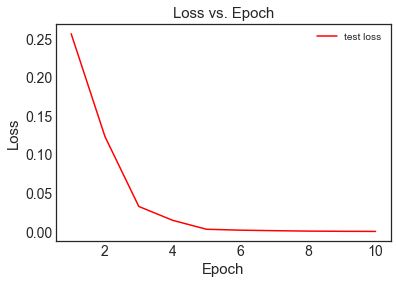

In [16]:
# Display loss vs epoch graph for train Data. See \output_Q2\Loss.png
analyser=Analyser(output2)
analyser.plot_loss(hist,'Loss')  

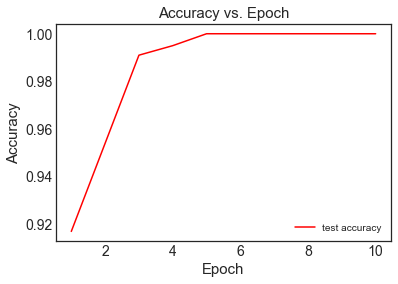

In [17]:
# Display loss vs epoch graph for train Data. See \output_Q2\Accuracy.png
analyser.plot_accuracy(hist,'Accuracy')

### Testing and Validation data indicates the model can achive a conssitent accuracy of around 86 %

In [18]:
#Evaluate trained network with test data
param= network.evaluate(X_Test, y_test,batch_size=bestParam.get('batch_size'))

100/100 [==============================] - 6s 61ms/step


In [19]:
#Print results of test data
print('Test loss:', param[0])
print('Test accuracy:', param[1]*100)
print('Test precision:', param[2]*100)
print('Test recall:', param[3]*100)
print('Test false negative:', param[4])
print('Test false positive:', param[5])
print('Test true negative:', param[6])
print('Test true positive:', param[7])


Test loss: 0.6449116264702752
Test accuracy: 86.79999709129333
Test precision: 67.34693646430969
Test recall: 66.00000262260437
Test false negative: 34.0
Test false positive: 32.0
Test true negative: 368.0
Test true positive: 66.0


In [20]:
#Evaluate trained network with validation data
param= network.evaluate(X_Val, y_Val,batch_size=bestParam.get('batch_size'))

100/100 [==============================] - 6s 64ms/step


In [21]:
#Print results of validation data
print('Validation loss:', param[0])
print('Validation accuracy:', param[1]*100)
print('Validation precision:', param[2]*100)
print('Validation recall:', param[3]*100)
print('Validation false negative:', param[4])
print('Validationt false positive:', param[5])
print('Validation true negative:', param[6])
print('Validation true positive:', param[7]) 

Validation loss: 0.4653364807367325
Validation accuracy: 86.40000224113464
Validation precision: 67.3913061618805
Validation recall: 62.00000047683716
Validation false negative: 38.0
Validationt false positive: 30.0
Validation true negative: 370.0
Validation true positive: 62.0


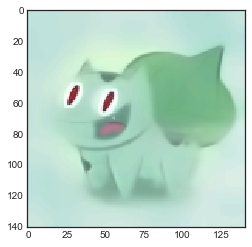

Actual img is: balbasaur
Predicted img is mewtwo



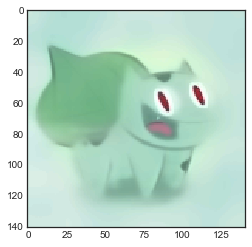

Actual img is: balbasaur
Predicted img is mewtwo



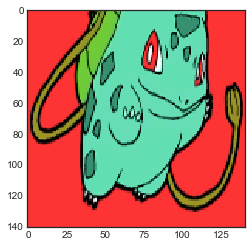

Actual img is: balbasaur
Predicted img is squirtle



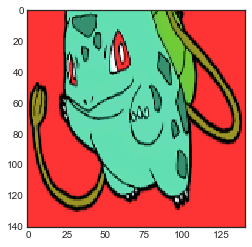

Actual img is: balbasaur
Predicted img is charmander



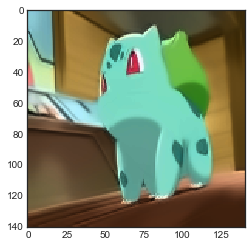

Actual img is: balbasaur
Predicted img is pikachu



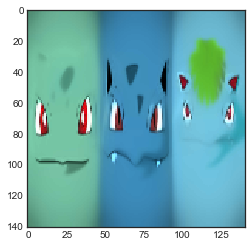

Actual img is: balbasaur
Predicted img is squirtle



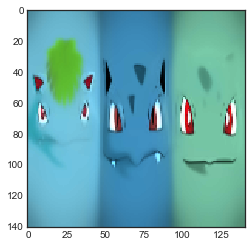

Actual img is: balbasaur
Predicted img is squirtle



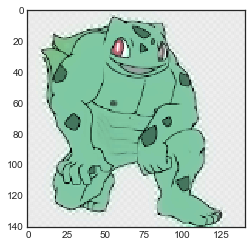

Actual img is: balbasaur
Predicted img is squirtle



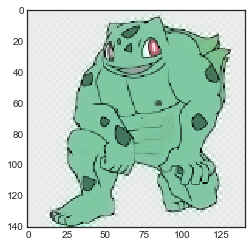

Actual img is: balbasaur
Predicted img is squirtle



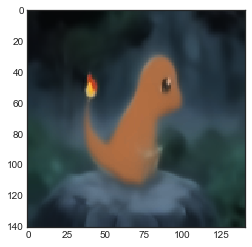

Actual img is: charmander
Predicted img is mewtwo



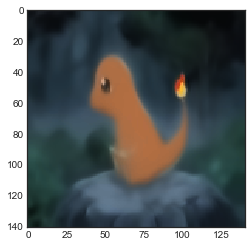

Actual img is: charmander
Predicted img is mewtwo



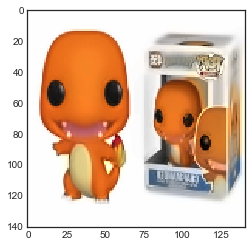

Actual img is: charmander
Predicted img is squirtle



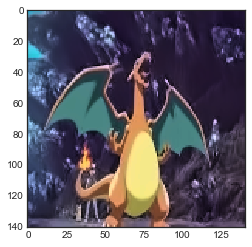

Actual img is: charmander
Predicted img is mewtwo



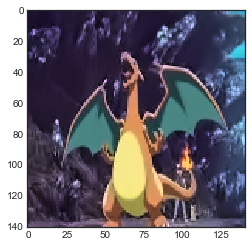

Actual img is: charmander
Predicted img is mewtwo



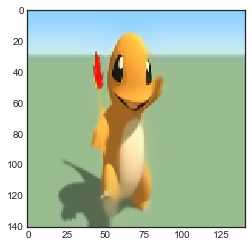

Actual img is: charmander
Predicted img is mewtwo



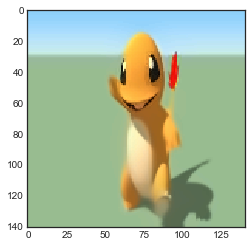

Actual img is: charmander
Predicted img is mewtwo



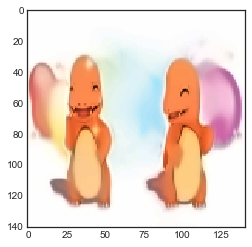

Actual img is: charmander
Predicted img is squirtle



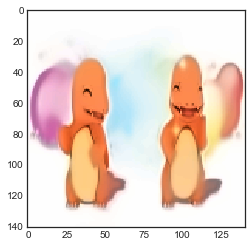

Actual img is: charmander
Predicted img is squirtle



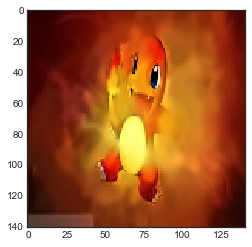

Actual img is: charmander
Predicted img is pikachu



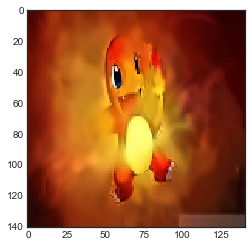

Actual img is: charmander
Predicted img is pikachu



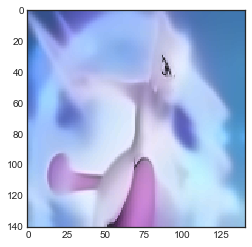

Actual img is: mewtwo
Predicted img is charmander



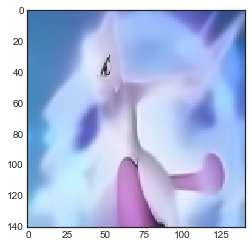

Actual img is: mewtwo
Predicted img is charmander



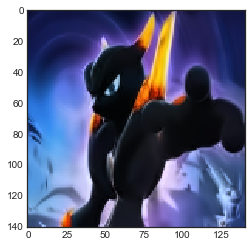

Actual img is: mewtwo
Predicted img is pikachu



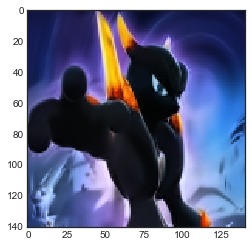

Actual img is: mewtwo
Predicted img is pikachu



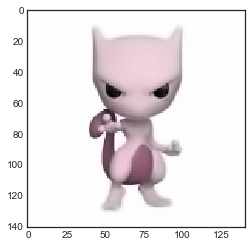

Actual img is: mewtwo
Predicted img is squirtle



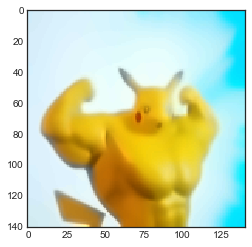

Actual img is: pikachu
Predicted img is charmander



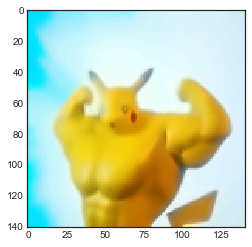

Actual img is: pikachu
Predicted img is charmander



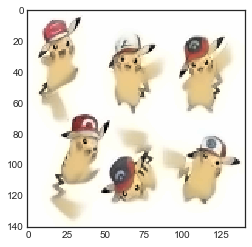

Actual img is: pikachu
Predicted img is squirtle



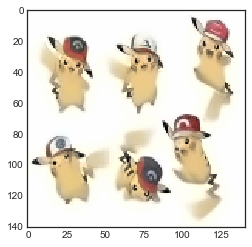

Actual img is: pikachu
Predicted img is squirtle



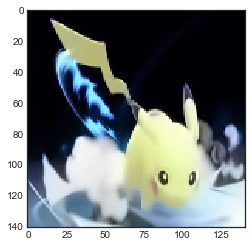

Actual img is: pikachu
Predicted img is squirtle



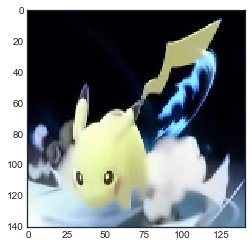

Actual img is: pikachu
Predicted img is squirtle



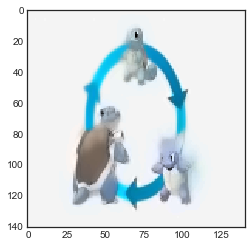

Actual img is: squirtle
Predicted img is balbasaur



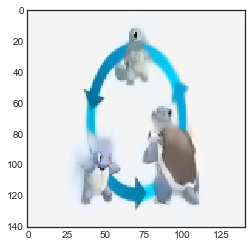

Actual img is: squirtle
Predicted img is balbasaur



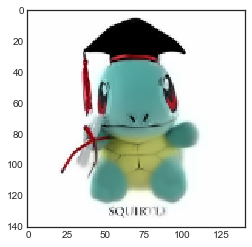

Actual img is: squirtle
Predicted img is balbasaur

Wrong 34
Right 66


In [22]:
# Validate model using validation img
# Display the predict result and actual validation image
# %matplotlib inline
import matplotlib.pyplot as plt

wrong,right=0,0
for index,anImage in enumerate(X_Val):
    
    actual = np.argmax(y_Val[index])
    actualStr=imgMan.getStrKeyFromVal(actual)

    prob = network.predict(np.expand_dims(anImage, axis=0))
    predictIndx = np.argmax(prob)
    predictStr=imgMan.getStrKeyFromVal(predictIndx)

    if actualStr !=predictStr:
        # print(actual)
        # print(predictIndx)
        plt.imshow(anImage)
        plt.show()
        print('Actual img is: '+ actualStr)
        print('Predicted img is '+predictStr +'\n')
        wrong+=1
    if actualStr ==predictStr:
        right+=1

    index+=1
print('Wrong '+str(wrong))
print('Right '+str(right))



In [23]:
import pickle
#Save Image manager and network model
data = [X_Test,y_test,X_Train,y_train,X_Val,y_Val]

with open(output2+'Q2_Data.pickle', 'wb+') as out_file:
    pickle.dump(data, out_file)
with open(output2+'Q2_ImageManager.pickle', 'wb+') as out_file:
    pickle.dump(imgMan, out_file)

network.save(output2+"Q2_CNN_model.h5") 
